In [64]:
# !pip install pyarrow

In [65]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

#import xgbtune 

In [66]:
df = pd.read_parquet("../data/dataset.parquet")
df

,date,open,high,low,close,adj close,volume,up_down_close_1,volitility_open_7,volitility_pct_change_7_open,...,close_percent_change_1_lag_60,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
0,2004-09-07,0.632143,0.646250,0.629107,0.638571,0.539257,301957600,1,NaN,NaN,...,NaN,1,7,9,2004,37,0.638571,0.638571,0.000000,0.000000
1,2004-09-08,0.637500,0.653036,0.637143,0.649107,0.548155,343526400,0,NaN,NaN,...,NaN,2,8,9,2004,37,0.638984,0.638676,0.000308,0.000247
2,2004-09-09,0.644643,0.648214,0.630000,0.637500,0.538353,461339200,1,NaN,NaN,...,NaN,3,9,9,2004,37,0.638926,0.638664,0.000262,0.000160
3,2004-09-10,0.636786,0.646964,0.633214,0.640536,0.540917,328014400,0,NaN,NaN,...,NaN,4,10,9,2004,37,0.638989,0.638683,0.000306,0.000164
4,2004-09-13,0.640714,0.644107,0.630714,0.635536,0.536694,281976800,0,NaN,NaN,...,NaN,0,13,9,2004,38,0.638854,0.638651,0.000202,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,2024-07-17,229.449997,231.460007,226.639999,228.880005,228.615387,57345900,0,3.289316,0.017871,...,0.005091,2,17,7,2024,29,207.897518,188.908818,18.988700,2.418547
4999,2024-07-18,230.279999,230.440002,222.270004,224.179993,223.920807,66034600,1,3.006525,0.017869,...,0.006392,3,18,7,2024,29,208.536046,189.259775,19.276271,2.164895
5000,2024-07-19,224.820007,226.800003,223.279999,224.309998,224.050659,49151500,0,3.906402,0.020045,...,0.012702,4,19,7,2024,29,209.154632,189.608533,19.546099,1.947778
5001,2024-07-22,227.009995,227.779999,223.089996,223.960007,223.701080,48201800,1,4.158552,0.020108,...,0.005147,0,22,7,2024,30,209.735235,189.950339,19.784897,1.749260


In [67]:
# target = "target_close"
target = "close_percent_change_1"
# target = "up_down_close_1"

x = df.drop(columns=[target]).set_index("date")
y = df[["date", target]].set_index("date")
y

,close_percent_change_1
date,
2004-09-07,0.016499
2004-09-08,-0.017881
2004-09-09,0.004762
2004-09-10,-0.007806
2004-09-13,-0.002810
...,...
2024-07-17,-0.020535
2024-07-18,0.000580
2024-07-19,-0.001560


In [68]:
table_info = pd.DataFrame()

# Print columns that are not int, float, bool or category
for col in x.columns:
    dtype = x[col].dtype
    if dtype not in ["int", "float64", "bool", "category"]:
        table_info = pd.concat([table_info, pd.DataFrame({"Column Name": [col], "Data Type": [x[col].dtype]})])

table_info

,Column Name,Data Type
0,crossed_close_bollinger_lower_30_close_event_name,object
0,crossed_close_close_bollinger_upper_30_event_name,object
0,dividends_event_name,object
0,splits_event_name,object


In [69]:
# Convert columns to float if they are not int, float, bool or category. Handle Cannot cast DatetimeArray to dtype float64 (XGBoosted models cannot use strings, but categories as enumerated values)
for col in x.columns:
    dtype = x[col].dtype
    if dtype not in ["int", "float64", "bool", "category"]:
        try:
            x[col] = x[col].astype("float")
        except:
            # drop datetime columns
            x = x.drop(columns=[col])

            print(f"Dropped Column: {col}")

Dropped Column: crossed_close_bollinger_lower_30_close_event_name
Dropped Column: crossed_close_close_bollinger_upper_30_event_name
Dropped Column: dividends_event_name
Dropped Column: splits_event_name


In [70]:
# # Normalizing the features between 0 and 1
# y_scaler = MinMaxScaler()
# y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# x_scaler = MinMaxScaler()
# x = x_scaler.fit_transform(x)

# y

In [71]:
#    All Features   | Target
# +-----------------+---------+
# | x_train         | y_train | <- 85% of the data which is used for training
# |                 |         |
# +-----------------+---------+
# | x_test          | y_test  | <- 15% of the data which is used for testing
# +-----------------+---------+


# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
# x_train

In [72]:
# y_test

In [73]:
x_train

,open,high,low,close,adj close,volume,up_down_close_1,volitility_open_7,volitility_pct_change_7_open,high_low_7,...,close_percent_change_1_lag_60,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
date,,,,,,,,,,,,,,,,,,,,,
2007-05-15,3.913214,3.935714,3.802857,3.840000,3.242785,954514400,0,0.113802,0.008476,0.132857,...,0.012613,1,15,5,2007,20,3.446544,3.037083,0.409461,0.033082
2014-05-19,21.351786,21.690357,21.333214,21.592501,19.077248,317755200,1,0.161879,0.008664,0.357143,...,0.004379,0,19,5,2014,21,20.063368,18.914868,1.148501,0.126826
2008-10-20,3.563571,3.572500,3.344286,3.515714,2.968934,1549170000,0,0.323306,0.114781,0.228214,...,-0.047619,0,20,10,2008,43,4.608204,5.351067,-0.742862,-0.126886
2019-08-12,49.904999,50.512501,49.787498,50.119999,48.498314,89927600,1,0.849551,0.022454,0.725002,...,-0.005682,0,12,8,2019,33,50.093592,47.960325,2.133267,-0.030692
2017-02-17,33.775002,33.957500,33.775002,33.930000,31.593916,88792800,1,0.397561,0.005970,0.182499,...,0.000627,4,17,2,2017,7,30.830978,28.400096,2.430883,0.281956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-06,3.155000,3.157143,2.940357,3.046429,2.572635,1011147200,0,0.053833,0.023580,0.216786,...,0.003409,4,6,3,2009,10,3.290738,4.093577,-0.802839,0.016667
2010-05-24,8.831429,8.960714,8.795000,8.812857,7.442240,754238800,0,0.308153,0.035527,0.165714,...,0.021357,0,24,5,2010,21,8.705562,7.433753,1.271809,-0.028125
2010-12-23,11.607143,11.612500,11.541786,11.557143,9.759722,223157200,1,0.064663,0.003396,0.070714,...,-0.012597,3,23,12,2010,51,11.101129,9.706793,1.394336,0.004348


In [74]:
import numpy

from itertools import count, takewhile
def frange(start, stop, step):
    return takewhile(lambda x: x< stop, count(start, step))

# list(frange(0, 1, 0.1))
numpy.linspace(5, 10, num=6).tolist()

[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [75]:
y_train

,close_percent_change_1
date,
2007-05-15,-0.001674
2014-05-19,0.000198
2008-10-20,-0.070601
2019-08-12,0.042348
2017-02-17,0.007221
...,...
2009-03-06,-0.025674
2010-05-24,-0.006241
2010-12-23,0.003337


In [76]:
from xgboost import XGBClassifier

# model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=1, colsample_bytree=.3)
# model = xgb.XGBRegressor(n_estimators=150, max_depth=7, eta=0.05, subsample=1, colsample_bytree=.3)
# model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.05, subsample=1, colsampvle_bytree=.3)
model = XGBClassifier(n_estimators=500, max_depth=5, eta=0.05, subsample=0.9, colsample_bytree=0.4)
model.fit(x_train, y_train)



pickle.dump(model, open("../model/xgboost_model.pkl", "wb")) # Save model as Python pickle object
model.save_model("../model/xgboost_model.json")

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3990 3991 3992], got [-0.1791952  -0.12864696 -0.12355785 ...  0.12557515  0.13157265
  0.13904945]

In [ ]:
# print(model.best_params_)
# model


In [ ]:
predicted = model.predict(x_test)
y_test["predicted"] = predicted
y_test

,up_down_close_1,predicted
date,,
2009-08-04,0,0
2012-10-05,0,0
2015-05-14,0,0
2016-06-07,0,0
2013-10-25,1,1
...,...,...
2014-03-06,0,0
2020-08-03,1,1
2006-02-14,1,1


In [ ]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_test[target], y_test["predicted"])
print("accuracy:", accuracy)

balanced_accuracy_score = metrics.balanced_accuracy_score(y_test[target], y_test["predicted"])
print("balanced_accuracy_score:", balanced_accuracy_score)

recall = metrics.recall_score(y_test[target], y_test["predicted"])
print("recall:", recall)

precision = metrics.precision_score(y_test[target], y_test["predicted"])
print("precision:", precision)

average_precision = metrics.average_precision_score(y_test[target], y_test["predicted"])
print("average_precision:", average_precision)

f1 = metrics.f1_score(y_test[target], y_test["predicted"])
print("f1:", f1)

# more metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


accuracy: 0.999000999000999
balanced_accuracy_score: 0.998945147679325
recall: 1.0
precision: 0.9981060606060606
average_precision: 0.9981060606060606
f1: 0.9990521327014218


accuracy: 0.5153922542204568
recall: 0.6316793893129771
precision: 0.5287539936102237
f1: 0.5756521739130435

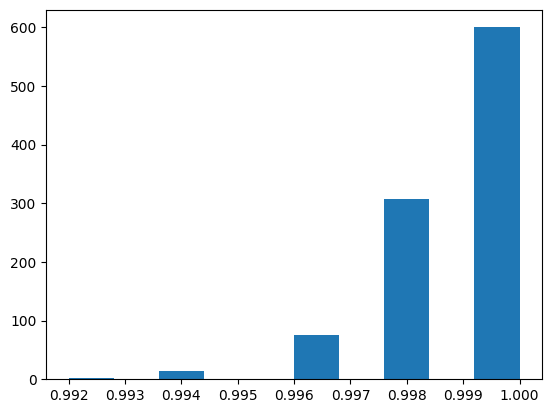

In [ ]:
# Confidaence interval
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# configure bootstrap
n_iterations = 1000
n_size = int(len(y_test) * 0.5)
# run bootstrap
stats = list()

for i in range(n_iterations):
    # prepare train and test sets
    test = resample(y_test, n_samples=n_size)
    # calculate accuracy
    accuracy = accuracy_score(test[target], test["predicted"])
    stats.append(accuracy)

# plot scores
plt.hist(stats)
plt.show()

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test[target], y_test["predicted"]))
# print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       474
           1       1.00      1.00      1.00       527

    accuracy                           1.00      1001
   macro avg       1.00      1.00      1.00      1001
weighted avg       1.00      1.00      1.00      1001



In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test[target], y_test["predicted"])


array([[473,   1],
       [  0, 527]])

In [ ]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# indices
# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print(f"{f + 1}. feature {x_train.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature close_percent_change_1 (0.3094238340854645)
2. feature open_lag_16 (0.02261383645236492)
3. feature close_lag_20 (0.020776741206645966)
4. feature close_percent_change_14 (0.02040109969675541)
5. feature close_percent_change_7 (0.019988063722848892)
6. feature high_lag_20 (0.016924183815717697)
7. feature high_lag_14 (0.015974147245287895)
8. feature open_lag_27 (0.01451281551271677)
9. feature low_lag_24 (0.014035358093678951)
10. feature open_lag_19 (0.013620608486235142)
11. feature high_bollinger_lower_30 (0.013194268569350243)
12. feature close_lag_28 (0.012614927254617214)
13. feature low_bollinger_upper_14 (0.01240550447255373)
14. feature open_bollinger_upper_7 (0.009750246070325375)
15. feature open_bollinger_upper_30 (0.00942930206656456)
16. feature open_lag_17 (0.008540648967027664)
17. feature open_bollinger_lower_14 (0.007936901412904263)
18. feature long_ema_200 (0.007855861447751522)
19. feature high_lag_27 (0.007850877940654755)
20. feature 

In [ ]:
# Save predicted values
y_test.sort_index().to_parquet("../data/predicted.parquet")